In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

Warning message:
"package 'DESeq2' was built under R version 4.2.2"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.2.1"

Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    exp

In [2]:
library(ComplexUpset)

Warning message:
"package 'ComplexUpset' was built under R version 4.2.2"


In [3]:
library(ggrepel)

Warning message:
"package 'ggrepel' was built under R version 4.2.1"


In [4]:
library(ComplexHeatmap)

Warning message:
"package 'ComplexHeatmap' was built under R version 4.2.1"
Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original fu

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [6]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'HOT1A3_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'HOT1A3', 'HOT1A3_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [7]:
hpath_df = hpath_df  %>% 
    extract(path, c("pathway"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(pathway = str_replace(pathway, "in photosynthetic organisms", "")) %>%
    mutate(pathway = str_trim(pathway))

In [8]:
hpath_df = hpath_df %>% 
    extract(sub, c("module"), "^[[:digit:]]* *([^\\[]+) *\\[?", remove = FALSE) %>%
    mutate(module = str_replace(module, "in photosynthetic organisms", "")) %>%
    mutate(module = str_replace(module, "metabolism", "")) %>%
    mutate(module = str_replace(module, "Biosynthesis of", "")) %>%
    mutate(module = str_replace(module, "Metabolism of", "")) %>%
    mutate(module = str_replace(module, "biosynthesis", "")) %>%
    mutate(module = str_trim(module)) 



In [9]:
hpath_df = hpath_df %>% 
    extract(ecpath, c("kegg_gene"), "^K[[:digit:]]+ *([^;]*);", remove = FALSE) 

In [10]:
hpath_df = hpath_df %>% 
    mutate(
        prev_gene = gene,
        gene = if_else(gene != '', gene, paste0('(',kegg_gene,')'))
        
    )

In [11]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";"),
         pathway = paste0(unique(pathway), collapse = ";"),
         module = paste0(unique(module), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)

In [12]:
hpath_df %>% filter(module == 'Membrane transport') %>%
    extract(ecpath, c("system"), "^K[[:digit:]]+ *[^;]*; (.* system)", remove = FALSE) %>%
    mutate(system = if_else(str_detect(ecpath, 'preprotein translocase'), 'preprotein translocase', system)) %>%
    mutate(system = if_else(str_detect(ecpath, 'sec-independent protein translocase'), 'sec-independent protein translocase', system)) %>%
    #count(system)
    filter(is.na(system)) %>% distinct(ecpath)

ecpath
<chr>
"K12340 tolC, bepC, cyaE, raxC, sapF, rsaF, hasF; outer membrane protein"
"K08485 ptsO, npr; phosphocarrier protein NPr"
K12257 secDF; SecD/SecF fusion protein
K02193 ccmA; heme exporter protein A [EC:7.6.2.5]
K02194 ccmB; heme exporter protein B
K02195 ccmC; heme exporter protein C
K02196 ccmD; heme exporter protein D
"K03106 SRP54, ffh; signal recognition particle subunit SRP54 [EC:3.6.5.4]"
"K24821 atm1, pexA; ATP-binding cassette, subfamily B, heavy metal transporter"


# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

# Create DE df

# GOSEQ

In [13]:
df_all = read_csv(file.path('DE_results', 'HOT1A3_all_FC_results.csv'))

Rows: 47723 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): contrast, gene_id, Assay, contrast1
dbl (5): logFC, AveExpr, pvalue, padj, Length
lgl (2): down, up

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [14]:
df_all = left_join(df_all, hpath_df_to_export, by='gene_id')

In [15]:
goseq_res = read_csv(file.path('DE_results', 'HOT1A3_GOSEQ_results.csv'))

Rows: 3474 Columns: 18
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (13): category, PATH, pathway, main, Category, type, enrich, Assay, cont...
dbl  (5): over_represented_pvalue, padj, under_represented_pvalue, numDEInCa...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
head(goseq_res)

category,PATH,pathway,over_represented_pvalue,padj,under_represented_pvalue,numDEInCat,numInCat,main,Category,type,enrich,Assay,contrast,organism,sub,module,Group
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
09122,09122 Translation,Translation,1.299072e-15,2.598144e-14,1.0000000,32,76,09120 Genetic Information Processing,Genetic,down,sub,prot,C2vsC1_prot,HOT1A3,09122 Translation,Translation,Coculture
09105,09105 Amino acid metabolism,Amino acid metabolism,4.758852e-05,4.758852e-04,0.9999814,34,170,09100 Metabolism,Metabolism,down,sub,prot,C2vsC1_prot,HOT1A3,09105 Amino acid metabolism,Amino acid,Coculture
09102,09102 Energy metabolism,Energy metabolism,1.427825e-04,9.518832e-04,0.9999527,22,96,09100 Metabolism,Metabolism,down,sub,prot,C2vsC1_prot,HOT1A3,09102 Energy metabolism,Energy,Coculture
09142,09142 Cell motility,Cell motility,5.215697e-04,2.607849e-03,0.9998582,14,54,09140 Cellular Processes,Cellular,down,sub,prot,C2vsC1_prot,HOT1A3,09142 Cell motility,Cell motility,Coculture
09132,09132 Signal transduction,Signal transduction,8.809507e-03,3.523803e-02,0.9961261,18,99,09130 Environmental Information Processing,Environmental,down,sub,prot,C2vsC1_prot,HOT1A3,09132 Signal transduction,Signal transduction,Coculture
09101,09101 Carbohydrate metabolism,Carbohydrate metabolism,1.167235e-02,3.890784e-02,0.9938326,27,165,09100 Metabolism,Metabolism,down,sub,prot,C2vsC1_prot,HOT1A3,09101 Carbohydrate metabolism,Carbohydrate,Coculture


In [17]:
goseq_meta = goseq_res %>% distinct(contrast) %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C1")~ "Coculture", 
        str_detect(contrast, "3|5")~ "Axenic late", 
        TRUE~ "Axenic"
    )) %>% 
    mutate(
        Group = factor(Group, levels=c("Coculture", "Axenic", "Axenic late")),
        Assay = factor(Assay, levels=c("rna", "prot"))
          ) %>%
    arrange(Group, Assay, contrast) %>%
    column_to_rownames('contrast') 
goseq_meta 

,Assay,Group
,<fct>,<fct>
C1vsA1_rna,rna,Coculture
C2vsC1_rna,rna,Coculture
C3vsC1_rna,rna,Coculture
C4vsC1_rna,rna,Coculture
C5vsC1_rna,rna,Coculture
LATEvsC1P1_rna,rna,Coculture
C2vsC1_prot,prot,Coculture
C3vsC1_prot,prot,Coculture
C4vsC1_prot,prot,Coculture


In [18]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [19]:
goseq_pal_up_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'pink', "red"))
pupgoseq = goseq_pal_up_fun(seq(0, 6))
goseq_pal_down_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'lightblue', "blue"))
pdowngoseq = goseq_pal_down_fun(seq(0, 6))

In [20]:
goseq_pal_updown_fun = colorRamp2(c(-6, log10(0.05), 0,-log10(0.05), 6), c('blue', 'lightblue', "white", 'pink', "red"))


In [21]:
goseq_pal_fc_fun = colorRamp2(c(-4,-2,-1, 0, 1,2, 4), rev(RColorBrewer::brewer.pal(7, "BrBG")))
pfcgoseq = goseq_pal_fc_fun(seq(-10, 10, length.out = 20))
#pfcgoseq = goseq_pal_up_fun(c(-5, -2, 0, 2, 5))
#show_col(pfcgoseq)

In [22]:
group_pal = c(Coculture='darkgreen', Axenic='#A6BB8D','Axenic late'='darkred')


In [23]:
t(tail(goseq_res))

category,02030,02040,04216,00404,00590,00903
PATH,02030 Bacterial chemotaxis [PATH:ko02030],02040 Flagellar assembly [PATH:ko02040],04216 Ferroptosis [PATH:ko04216],00404 Staurosporine biosynthesis [PATH:ko00404],00590 Arachidonic acid metabolism [PATH:ko00590],00903 Limonene and pinene degradation [PATH:ko00903]
pathway,Bacterial chemotaxis,Flagellar assembly,Ferroptosis,Staurosporine biosynthesis,Arachidonic acid metabolism,Limonene and pinene degradation
over_represented_pvalue,1,1,1,1,1,1
padj,1,1,1,1,1,1
under_represented_pvalue,0.0001643705,0.0001900368,0.3746961557,0.3472556782,0.4080510802,0.3101116821
numDEInCat,0,0,0,0,0,0
numInCat,47,49,5,5,5,6
main,09140 Cellular Processes,09140 Cellular Processes,09140 Cellular Processes,09100 Metabolism,09100 Metabolism,09100 Metabolism
Category,Cellular,Cellular,Cellular,Metabolism,Metabolism,Metabolism
type,up,up,up,up,up,up


Warning message in brewer.pal(length(unique(module_mat$module)), "Set3"):
"minimal value for n is 3, returning requested palette with 3 different levels
"


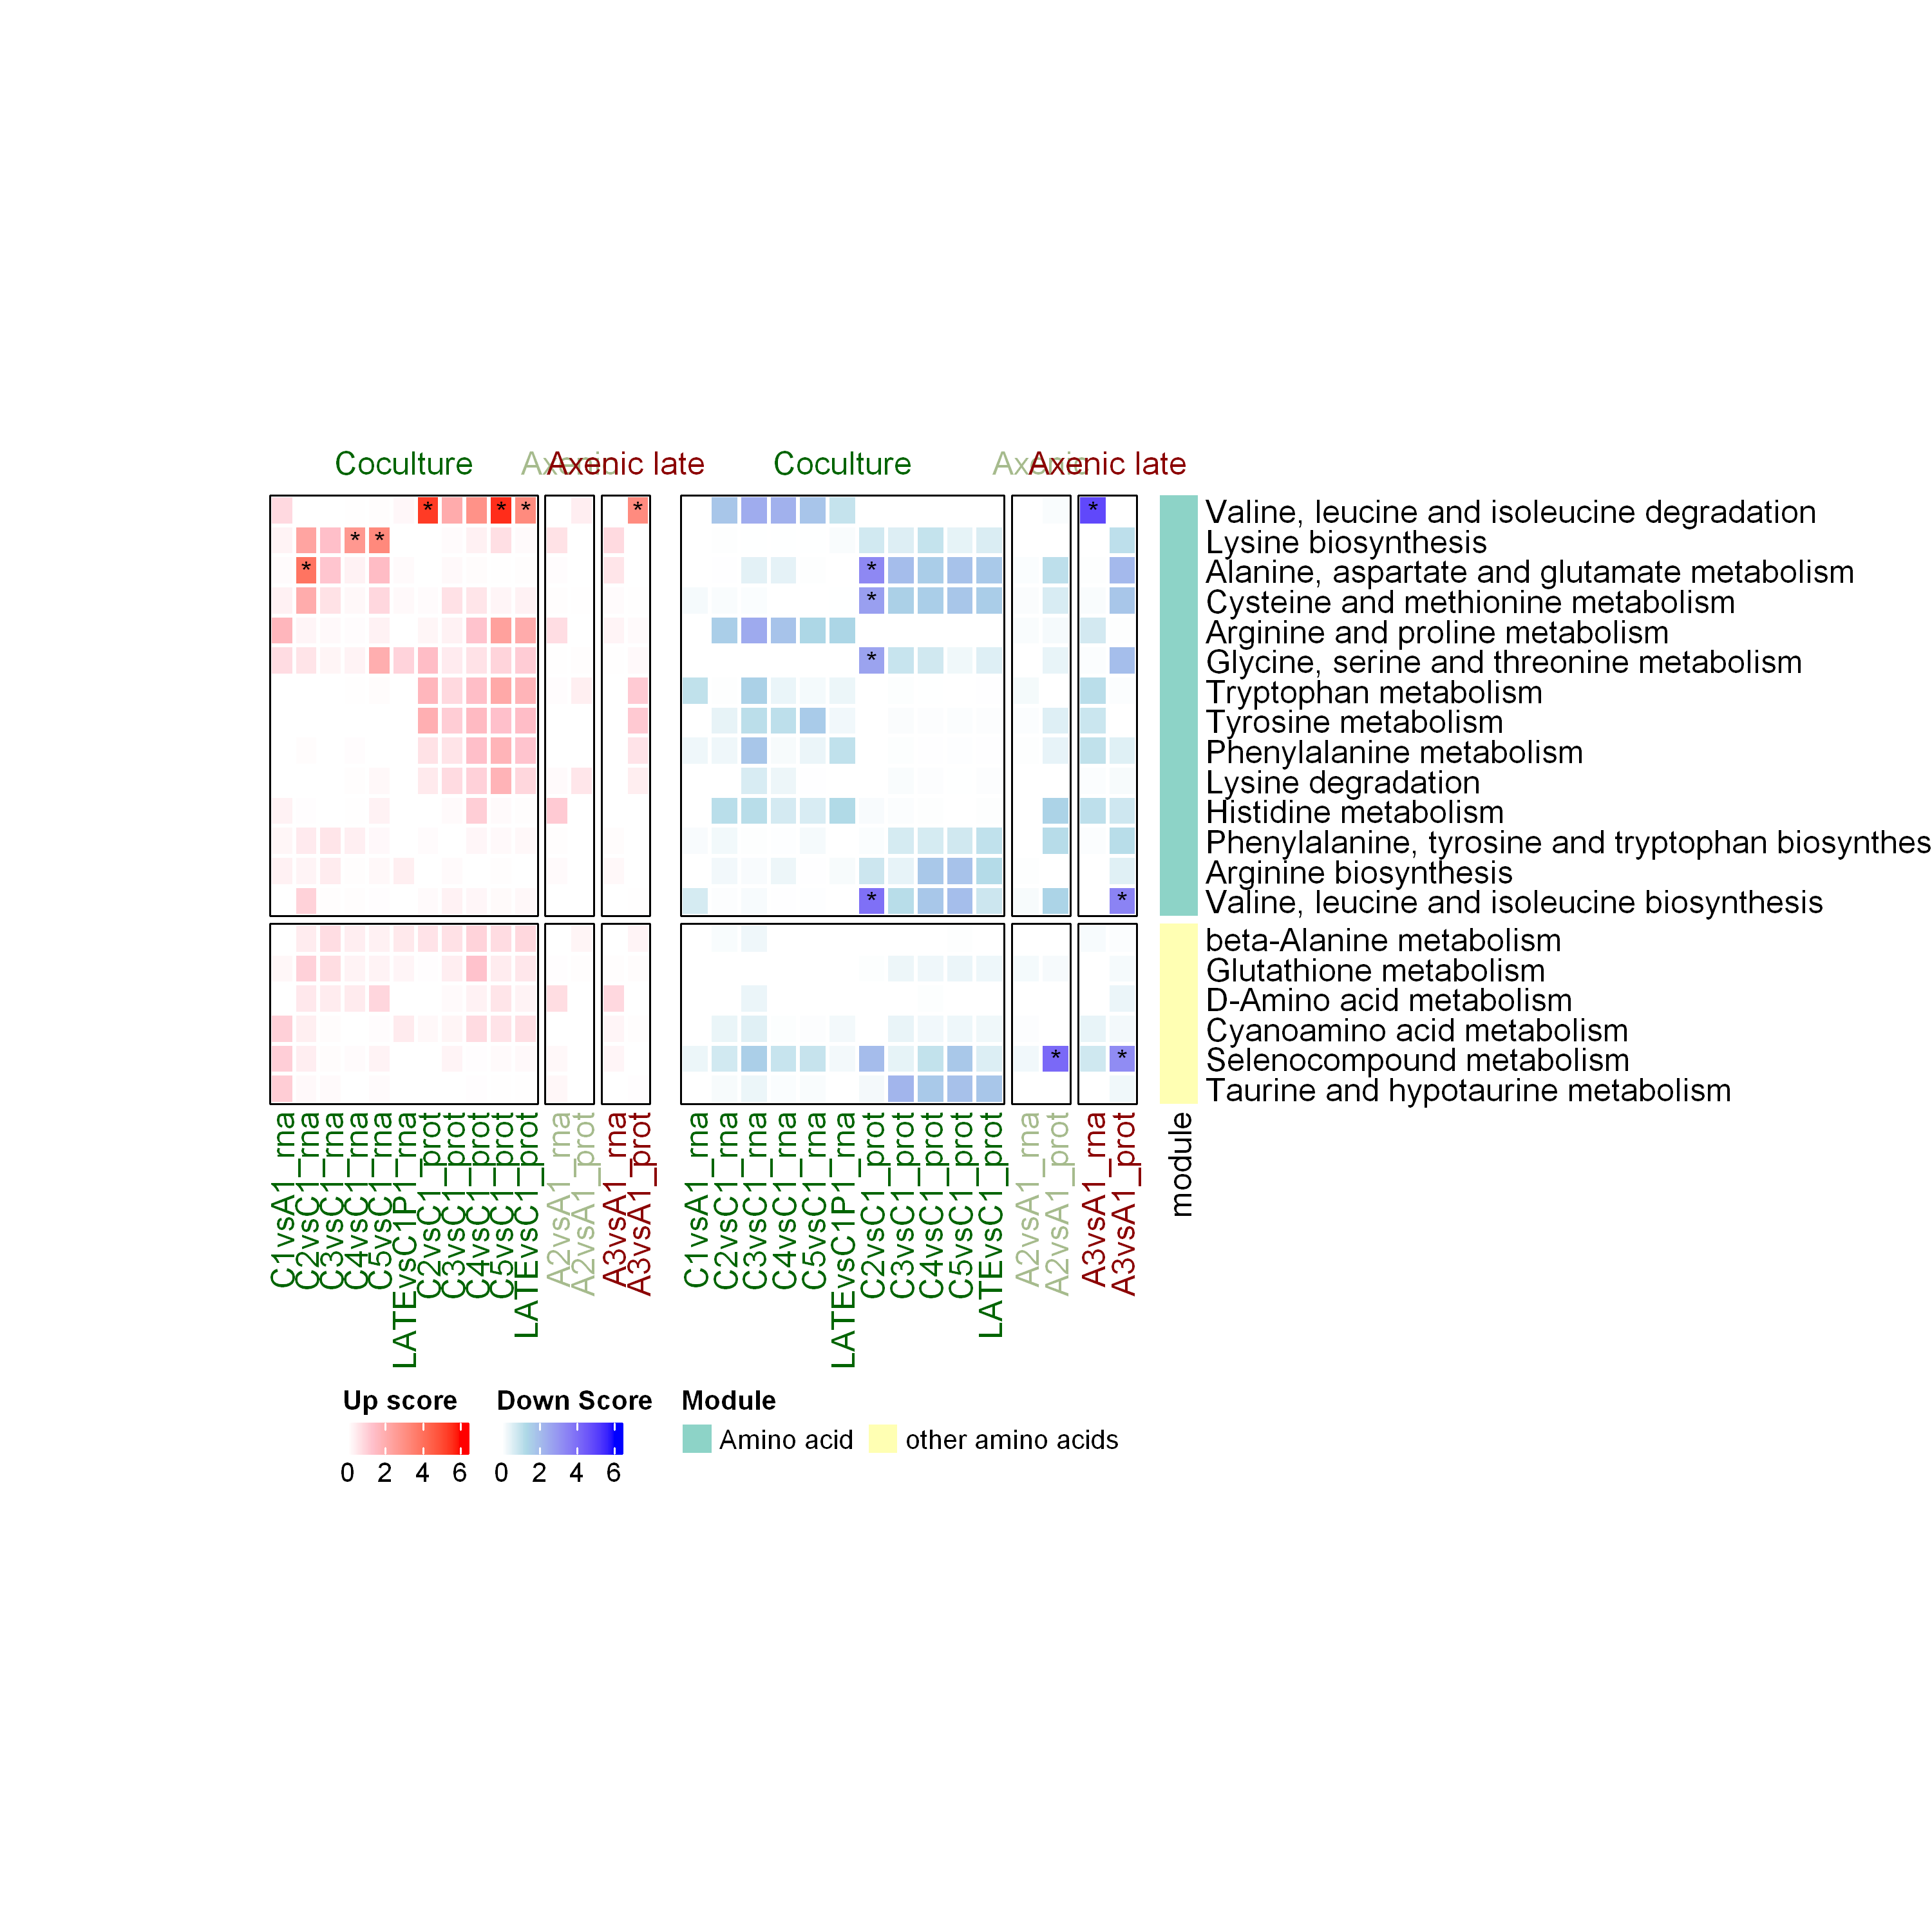

In [25]:
module_list = c('other amino acids', 'Amino acid')
toppaths = goseq_res %>% 
    filter(module %in% module_list, enrich %in% 'path') %>%
    distinct(pathway)

# row_ha = rowAnnotation(foo2 = runif(10), ))

module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
    distinct(pathway, module) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') 

# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    row_split = module_mat$module,
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(5, 'cm'),
    height=unit(8, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    relocate(rownames(goseq_meta)) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Down Score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    column_split = goseq_meta$Group,
    column_title_gp = gpar(col = group_pal),
    column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(6, 'cm'),
    height=unit(15, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

ann_mat = Heatmap(
    as.matrix(module_mat), 
    name='Module',
    width=unit(0.5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal", ncol=3),
    col = structure(brewer.pal(length(unique(module_mat$module)), "Set3"), names = unique(module_mat$module)),
    row_title=FALSE,
)

ht_list = up_mat + down_mat + ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

In [26]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

# Heatmap per Module

In [27]:
genome = 'HOT1A3'

In [28]:
modules_de = goseq_res %>% 
    filter(padj < 0.05) %>% 
    count(module)



In [29]:
deg = df_all %>% filter(padj < 0.05) %>% distinct(gene_id)
hpath_df %>% 
    filter(gene_id %in% deg$gene_id, module %in% modules_de$module) %>% 
    distinct(gene_id, module) %>%
    count(module) %>% arrange(n)



module,n
<chr>,<int>
terpenoids and polyketides,25
"Folding, sorting and degradation",40
Xenobiotics biodegradation and,40
other secondary metabolites,40
Glycan and,47
other amino acids,52
Membrane transport,64
Lipid,66
Nucleotide,71


## Membrane transport

In [96]:
module_name = 'Membrane transport'
module_title = paste0(genome, ' ',module_name)

In [97]:
toppaths = goseq_res %>% 
    filter(module %in% module_name) %>% 
    distinct(pathway)

In [98]:
toppaths

pathway
<chr>
Membrane transport
Bacterial secretion system
ABC transporters


In [99]:
degenes = hpath_df %>% 
    filter(module %in% module_name
           ) %>% 
    distinct(gene_id)

In [100]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [101]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [102]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


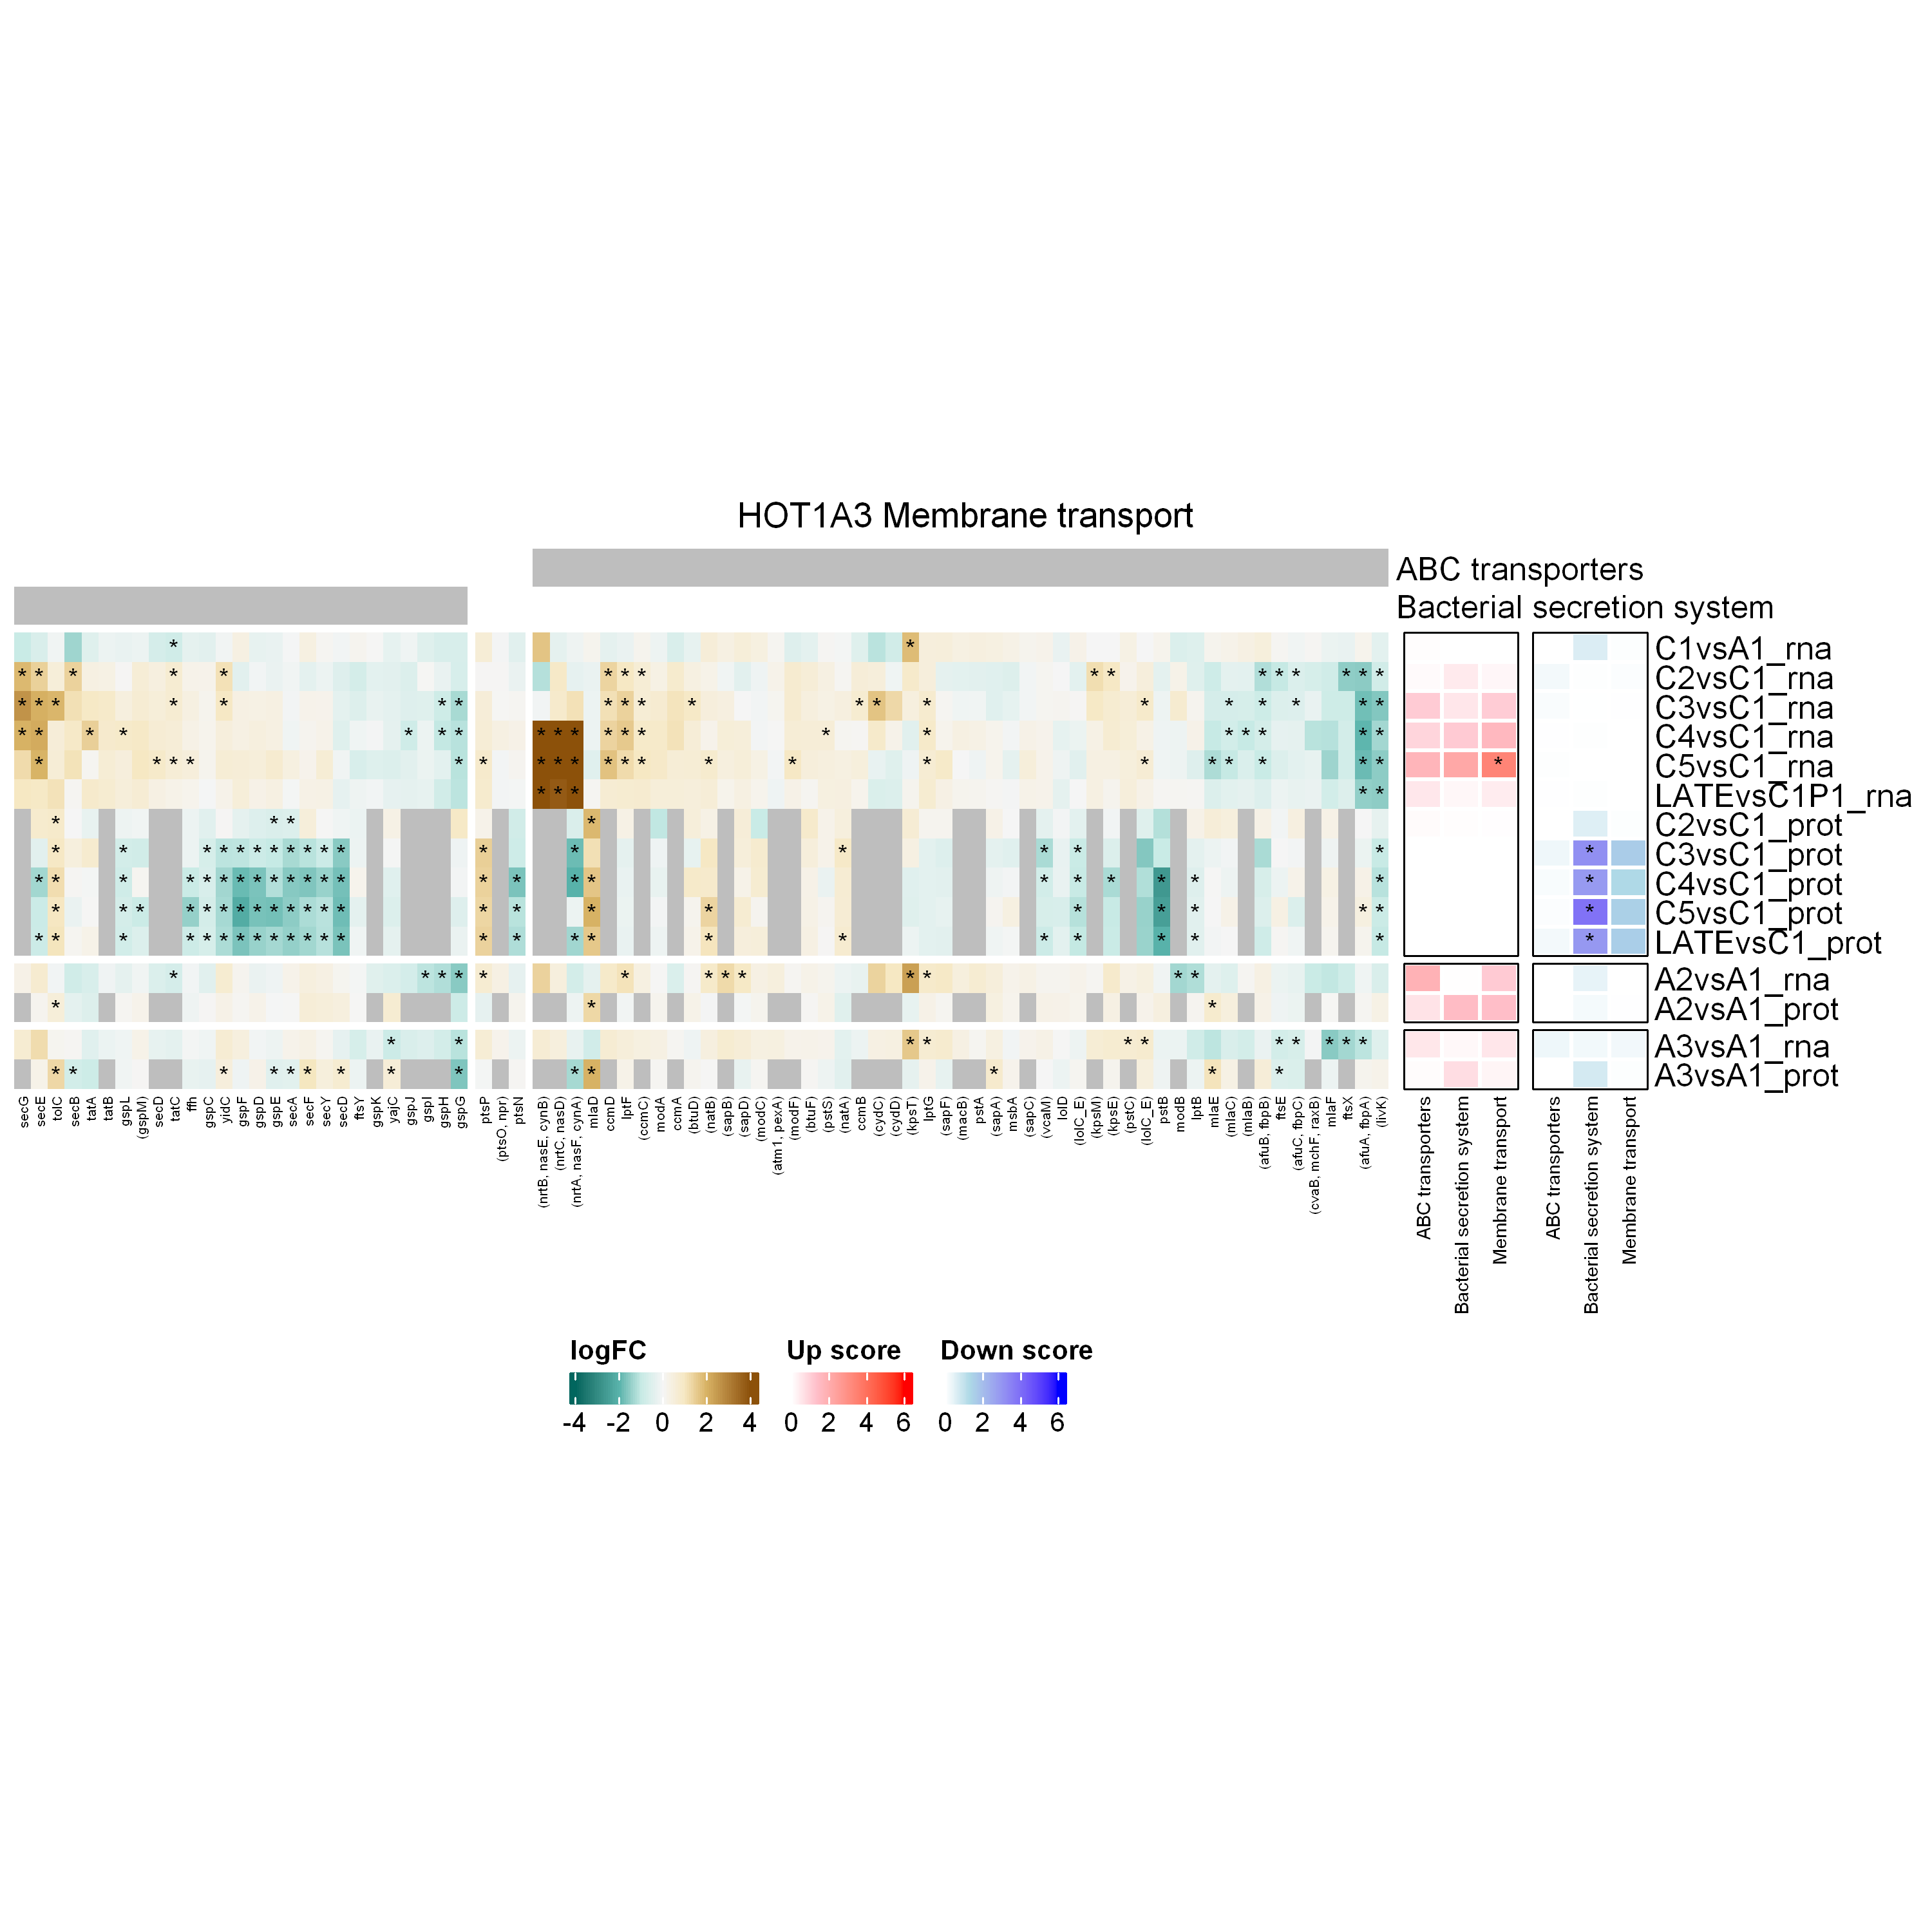

In [103]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    #show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## other amino acids 

In [30]:
module_name = 'other amino acids'
module_title = paste0(genome, ' ',module_name)

In [31]:
toppaths = goseq_res %>% 
    filter(module %in% module_name) %>% 
    distinct(pathway)

In [32]:
toppaths

pathway
<chr>
Metabolism of other amino acids
Selenocompound metabolism
Taurine and hypotaurine metabolism
Glutathione metabolism
beta-Alanine metabolism
Cyanoamino acid metabolism
D-Amino acid metabolism


In [33]:
degenes = hpath_df %>% 
    filter(module %in% module_name
           ) %>% 
    distinct(gene_id)

In [34]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [35]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [36]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


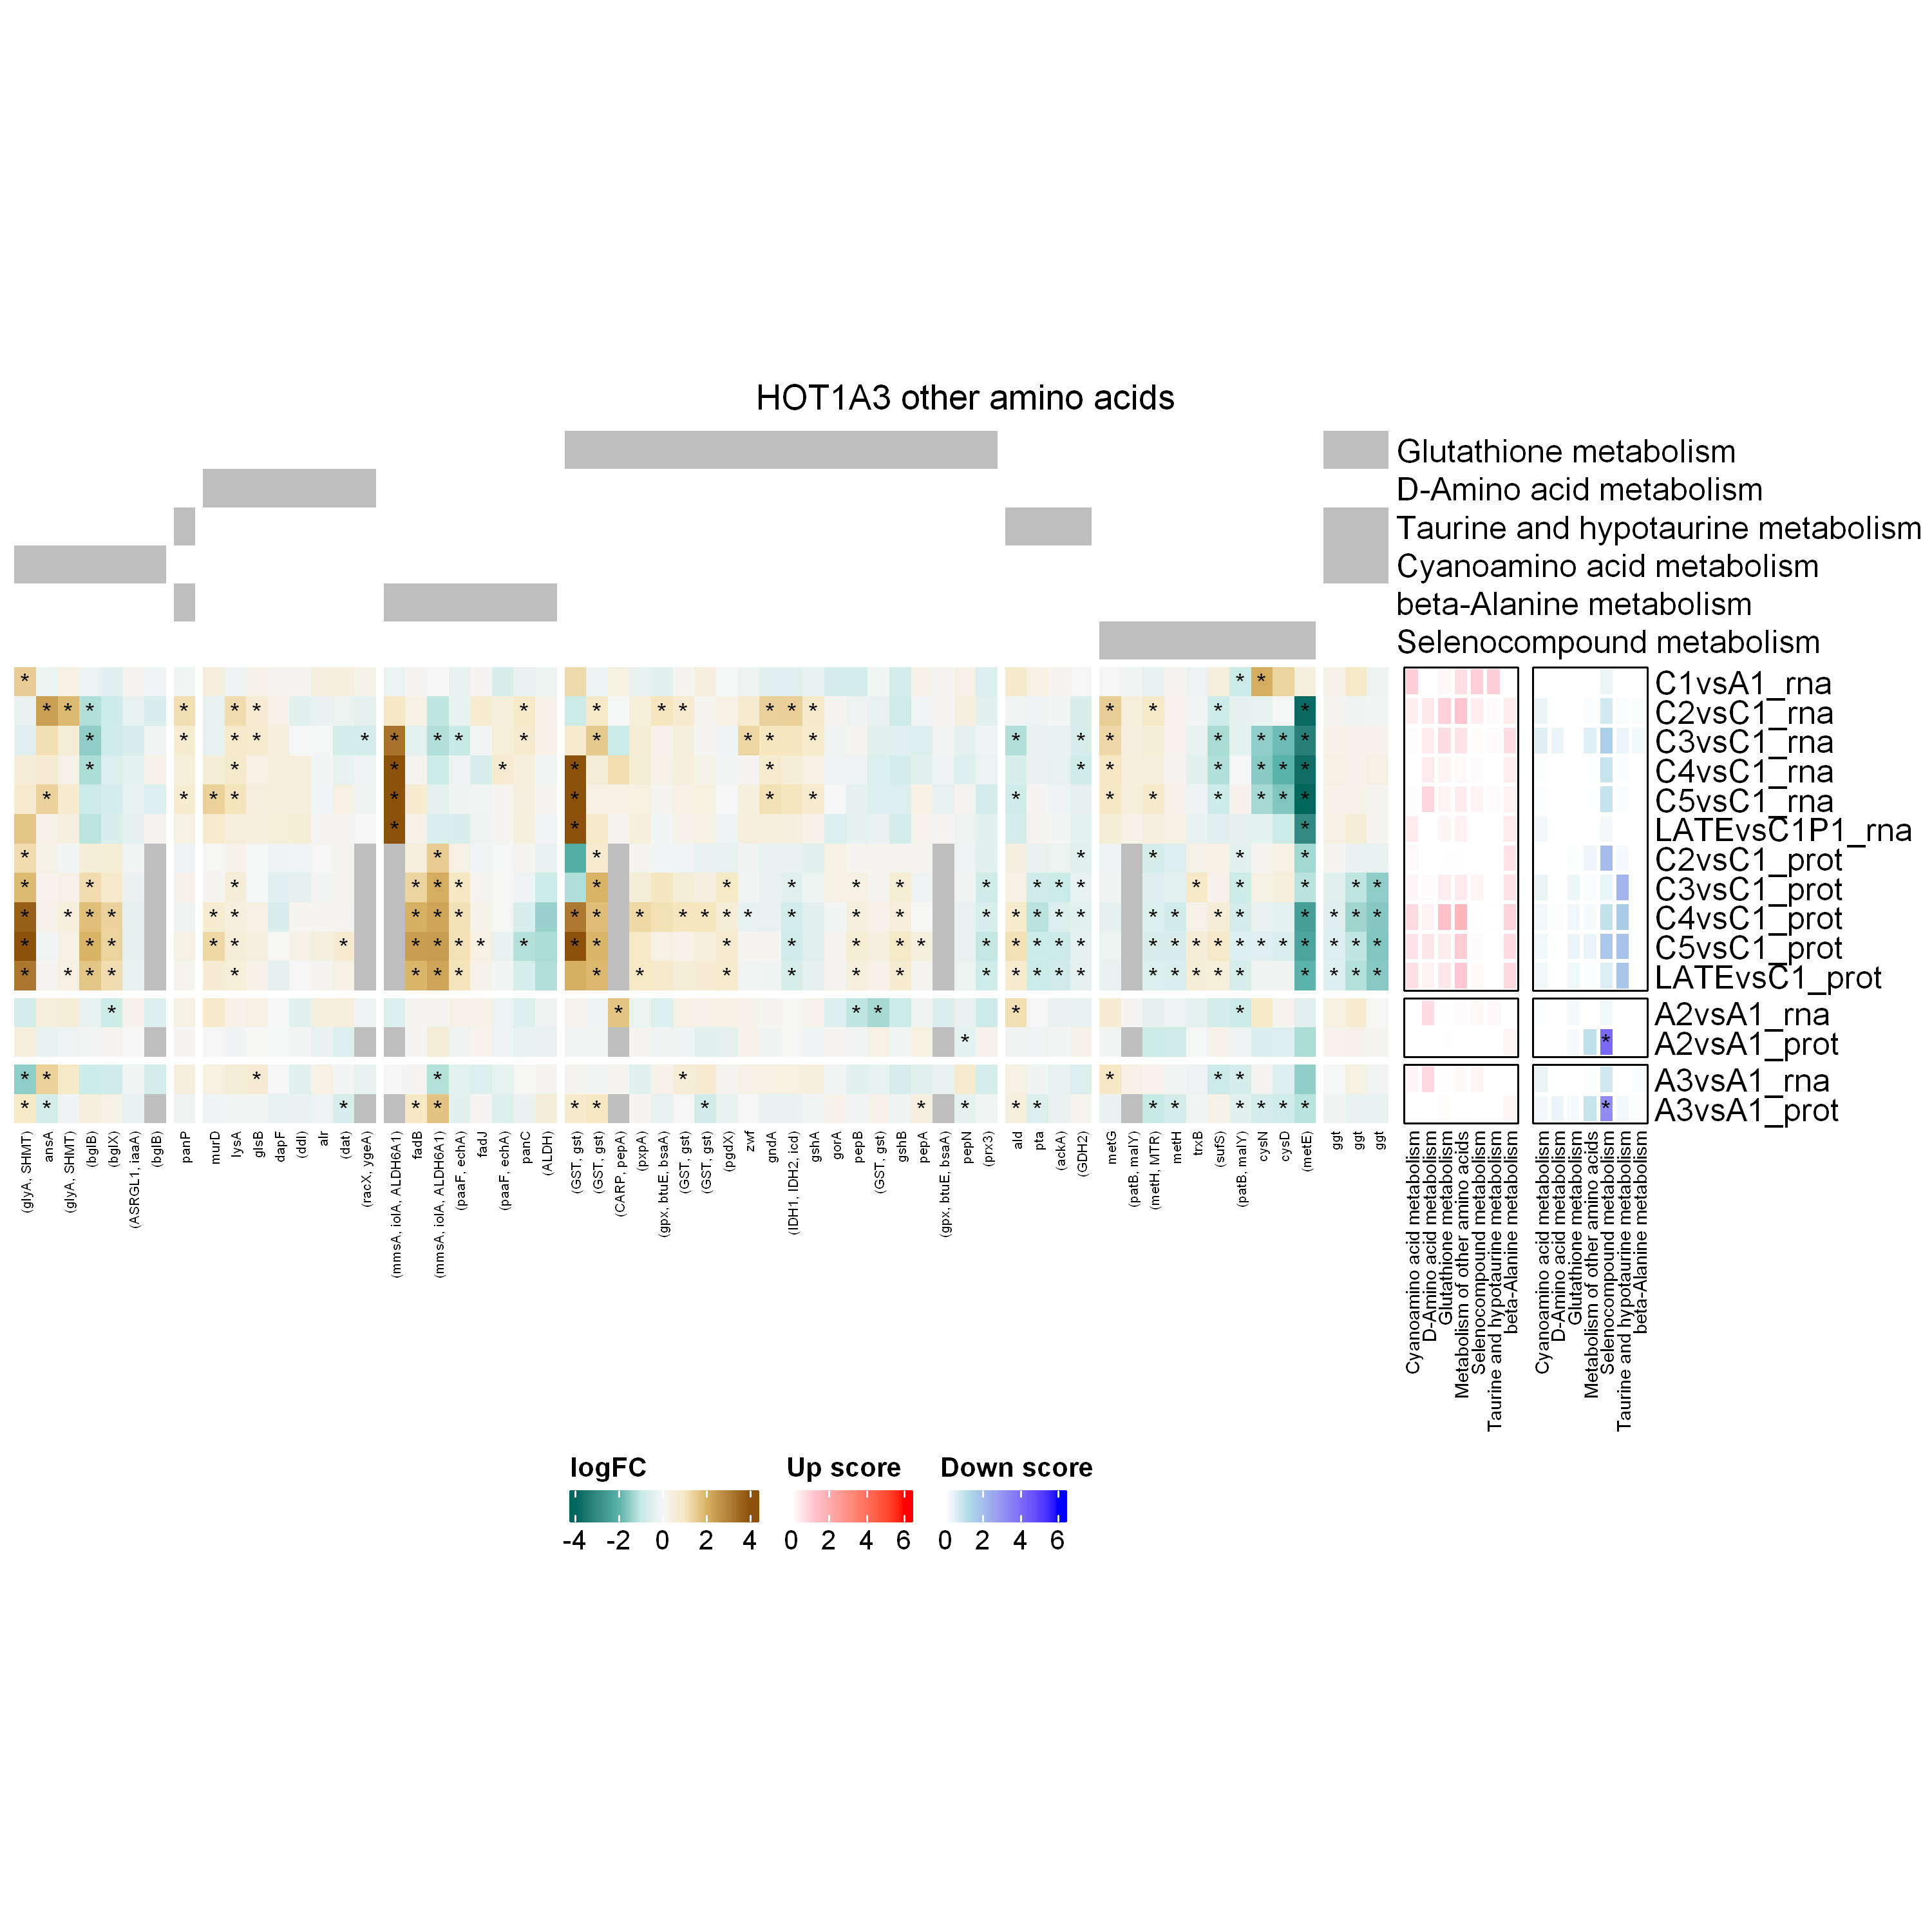

In [37]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    #show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Amino acid

In [38]:
aa_list_for_fig1 =  c(
"Alanine, aspartate and glutamate metabolism", "Phenylalanine, tyrosine and tryptophan biosynthesis", 
 "Arginine biosynthesis", 

"Arginine and proline metabolism")
                                                                           

In [76]:
aa_list_for_fig2 =  c("Cysteine and methionine metabolism", "Glycine, serine and threonine metabolism", 
 "Histidine metabolism", "Phenylalanine metabolism")

                                                                           

In [39]:
module_name = 'Amino acid'
module_title = paste0(genome, ' ',module_name)

In [40]:
toppaths = goseq_res %>% 
    filter(module %in% module_name) %>% 
    filter(pathway %in% aa_list_for_fig1) %>% 
    distinct(pathway)

In [41]:
toppaths

pathway
<chr>
"Alanine, aspartate and glutamate metabolism"
Arginine biosynthesis
"Phenylalanine, tyrosine and tryptophan biosynthesis"
Arginine and proline metabolism


In [42]:
degenes = hpath_df %>% 
    filter(module %in% module_name, 
           pathway %in% aa_list_for_fig1 
           ) %>% 
    distinct(gene_id)

In [43]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [44]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [45]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


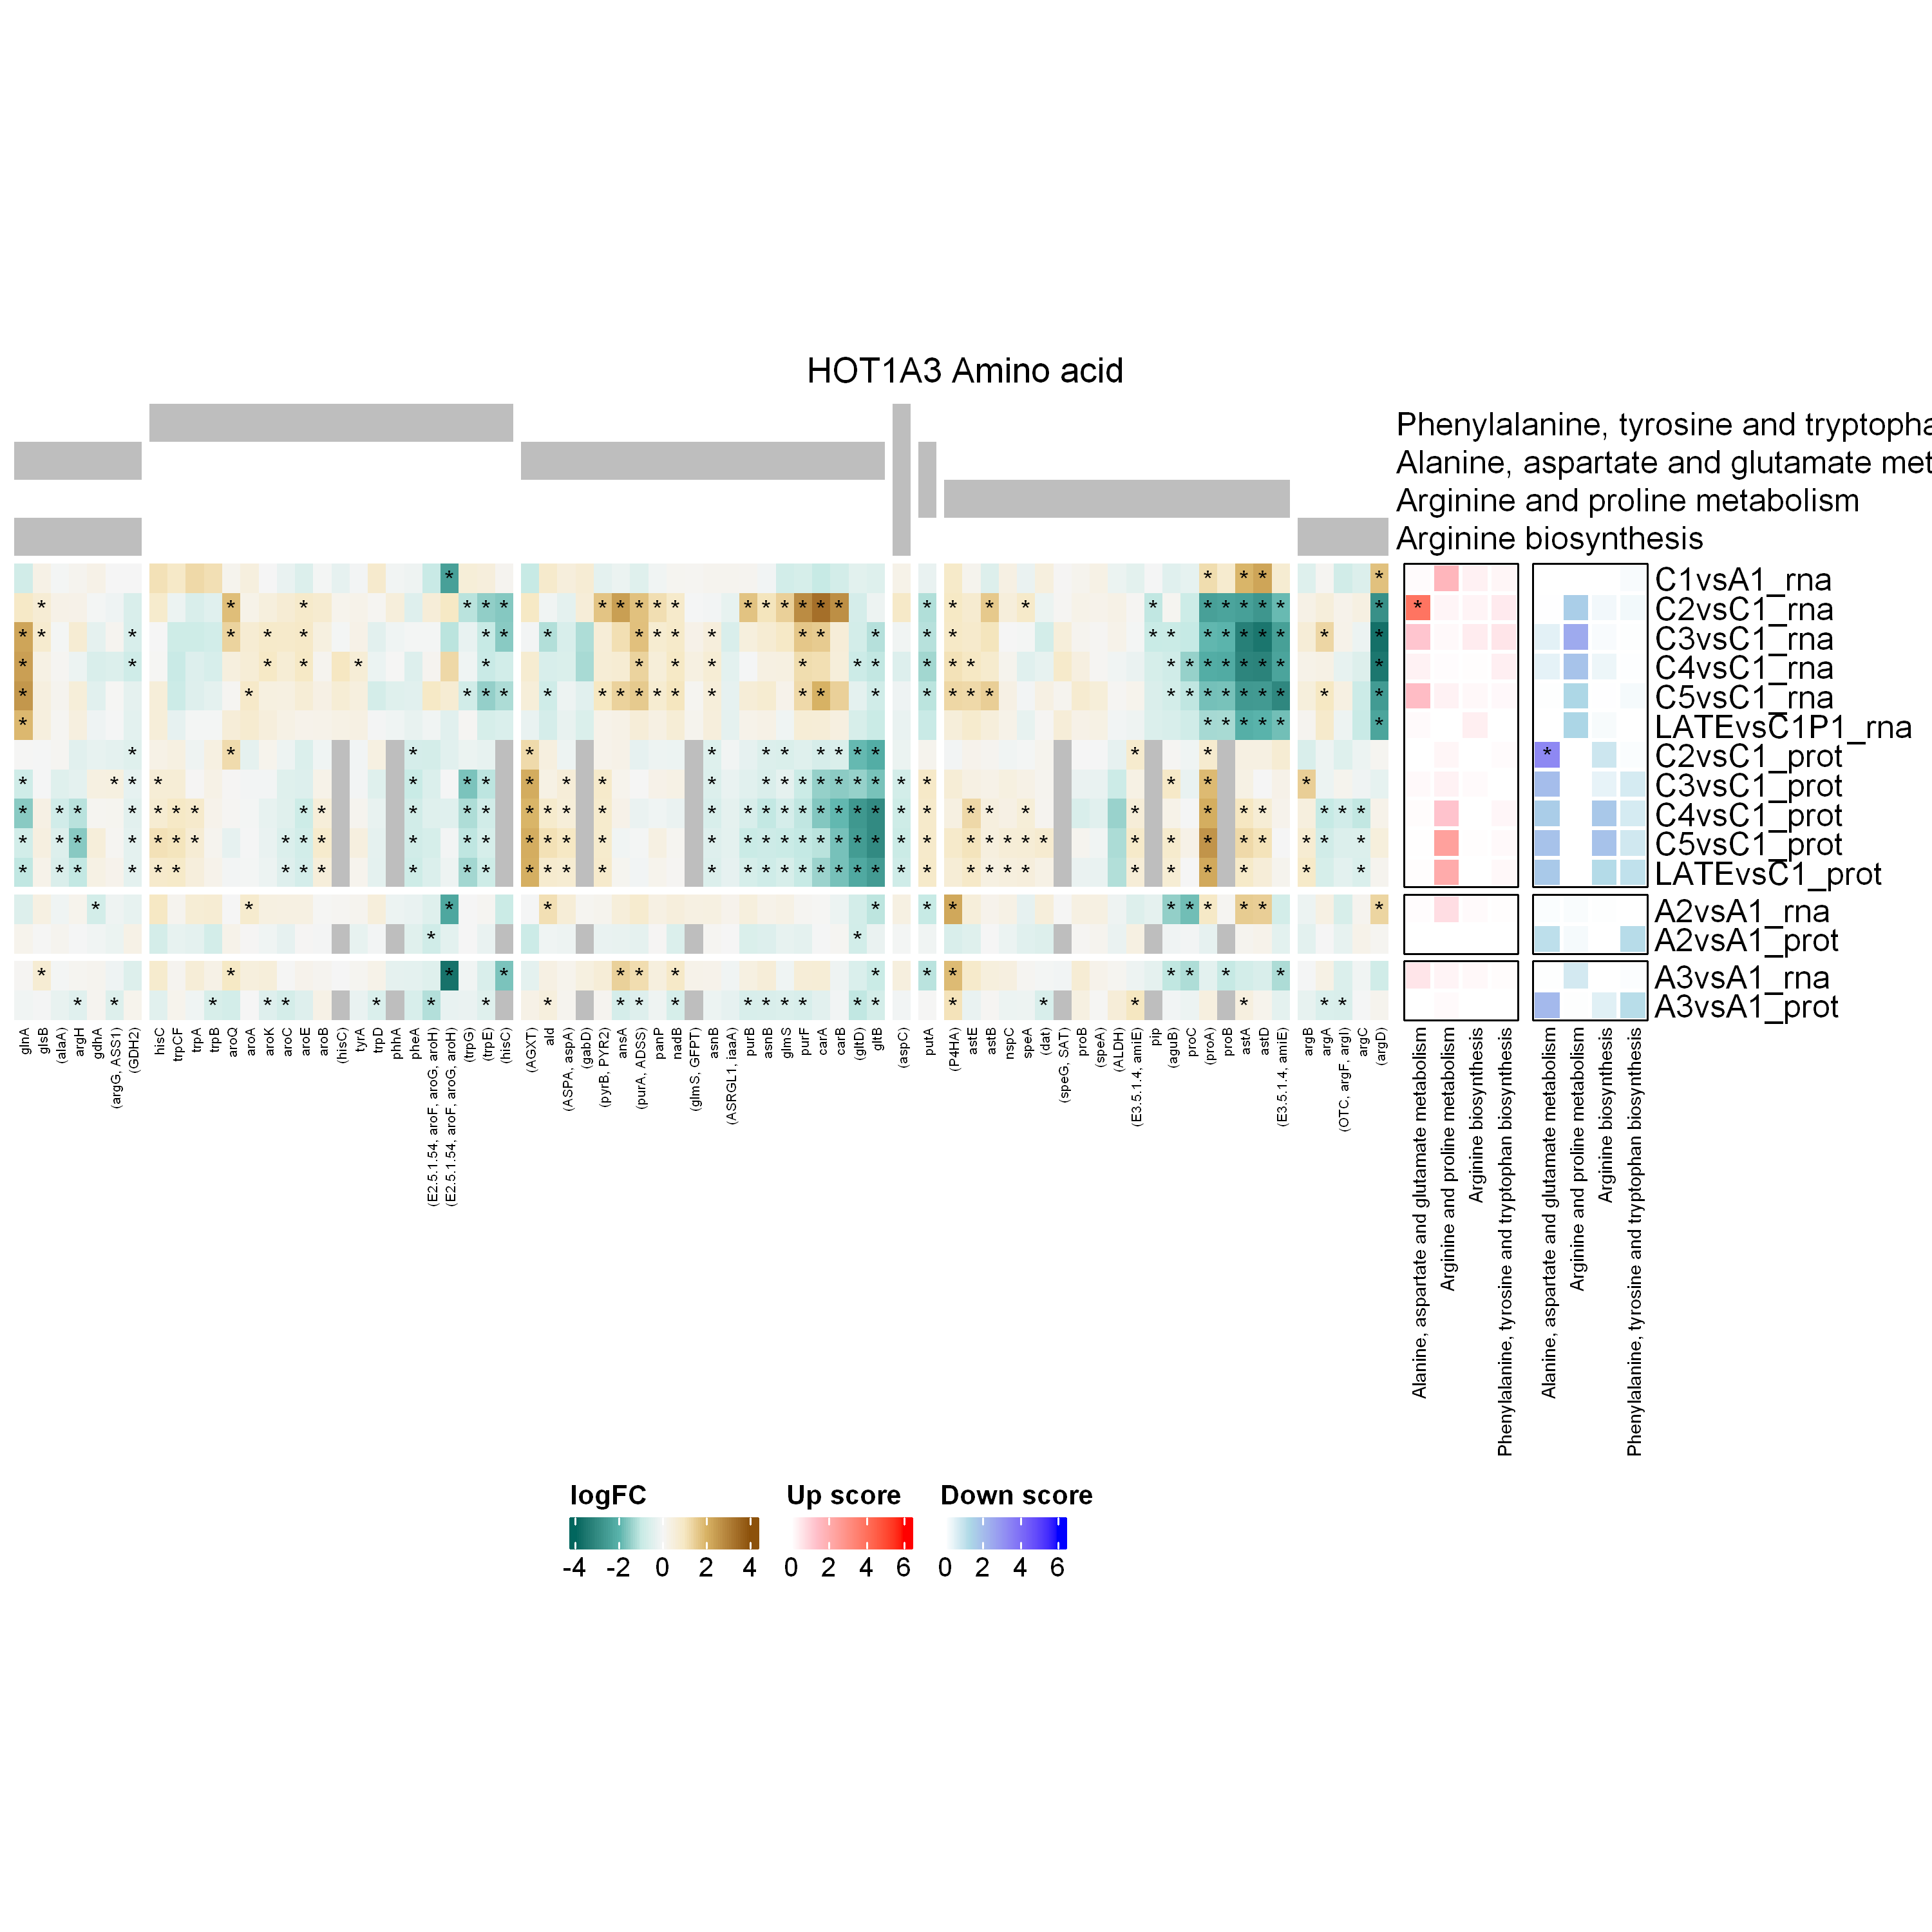

In [46]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    #show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Amino acid

## Amino acid fig2

In [77]:
module_name = 'Amino acid'
module_title = paste0(genome, ' ',module_name)

In [78]:
toppaths = goseq_res %>% 
    filter(module %in% module_name) %>% 
    filter(pathway %in% aa_list_for_fig2) %>% 
    distinct(pathway)

In [79]:
toppaths

pathway
<chr>
Cysteine and methionine metabolism
"Glycine, serine and threonine metabolism"
Histidine metabolism
Phenylalanine metabolism


In [80]:
degenes = hpath_df %>% 
    filter(module %in% module_name, 
           pathway %in% aa_list_for_fig2 
           ) %>% 
    distinct(gene_id)

In [81]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [82]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [83]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


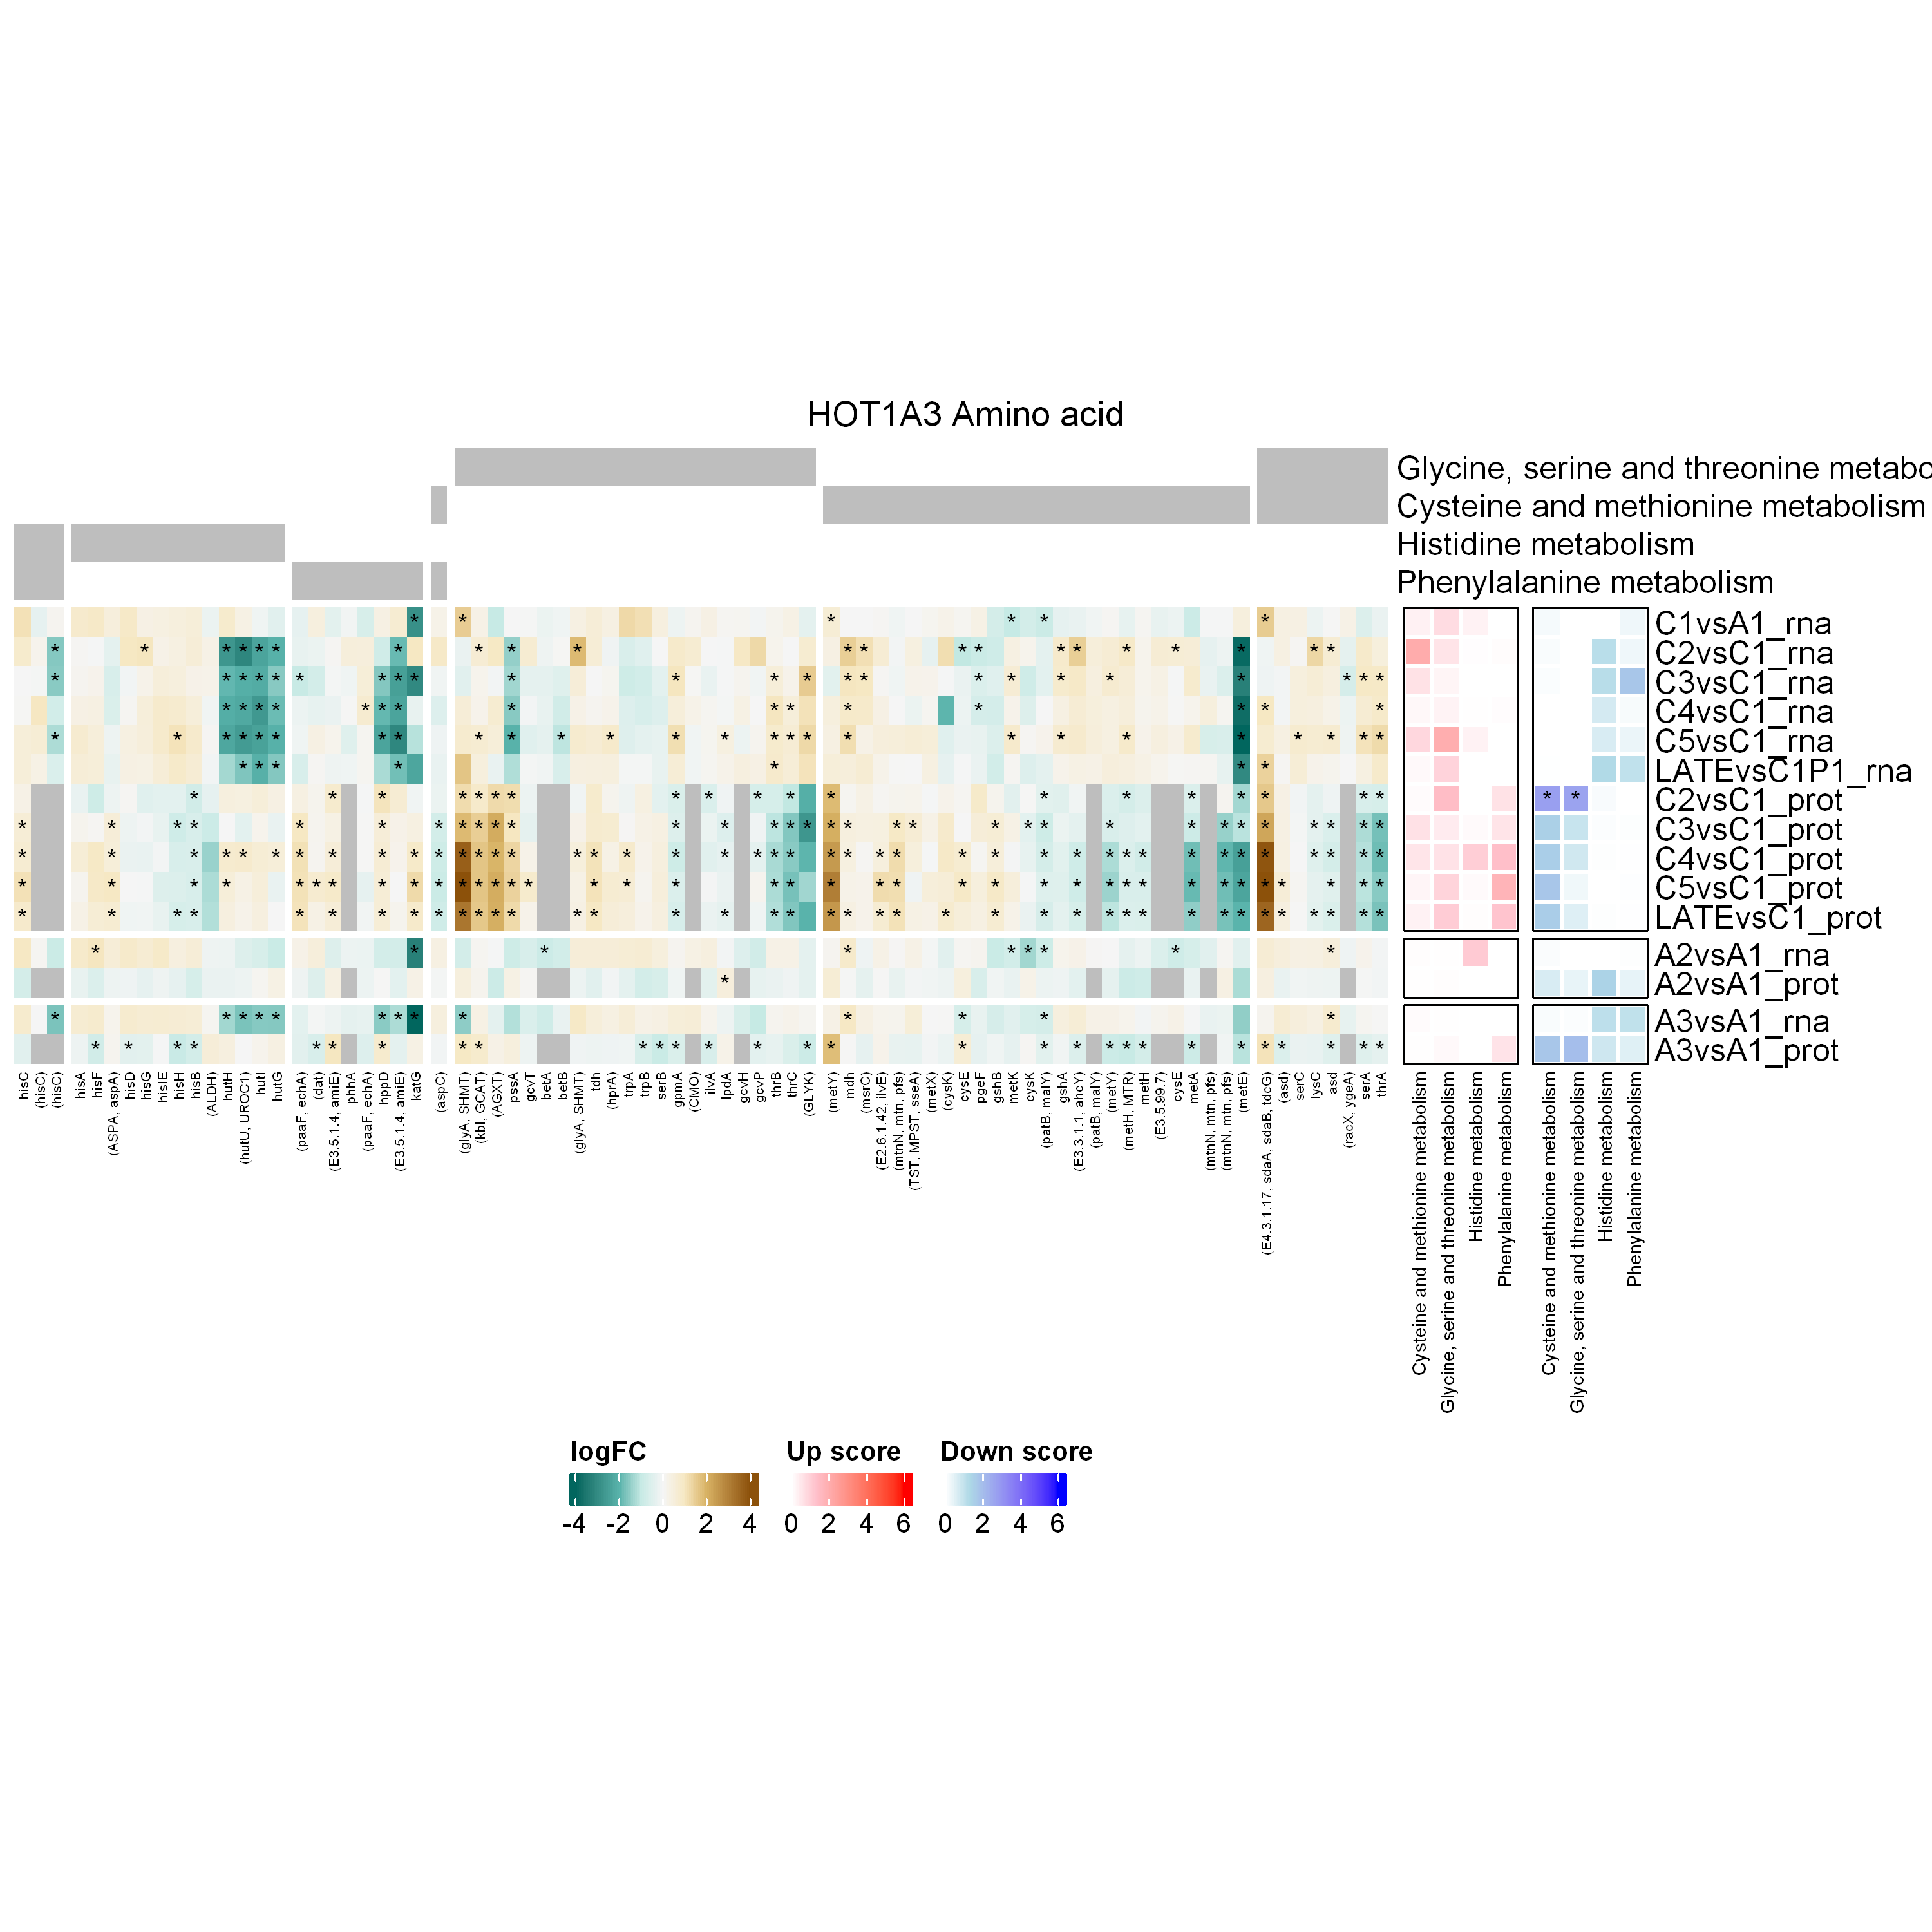

In [84]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    #show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Amino acid figure 3

In [85]:
module_name = 'Amino acid'
module_title = paste0(genome, ' ',module_name)

In [86]:
toppaths = goseq_res %>% 
    filter(module %in% module_name) %>% 
    filter(!(pathway %in% aa_list_for_fig1)) %>% 
    filter(!(pathway %in% aa_list_for_fig2)) %>% 
    distinct(pathway)

In [87]:
toppaths

pathway
<chr>
Amino acid metabolism
"Valine, leucine and isoleucine biosynthesis"
Lysine biosynthesis
"Valine, leucine and isoleucine degradation"
Lysine degradation
Tyrosine metabolism
Tryptophan metabolism


In [88]:
degenes = hpath_df %>% 
    filter(module %in% module_name, 
           !(pathway %in% aa_list_for_fig1),
           !(pathway %in% aa_list_for_fig2)
           ) %>% 
    distinct(gene_id)

In [89]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [90]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [91]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


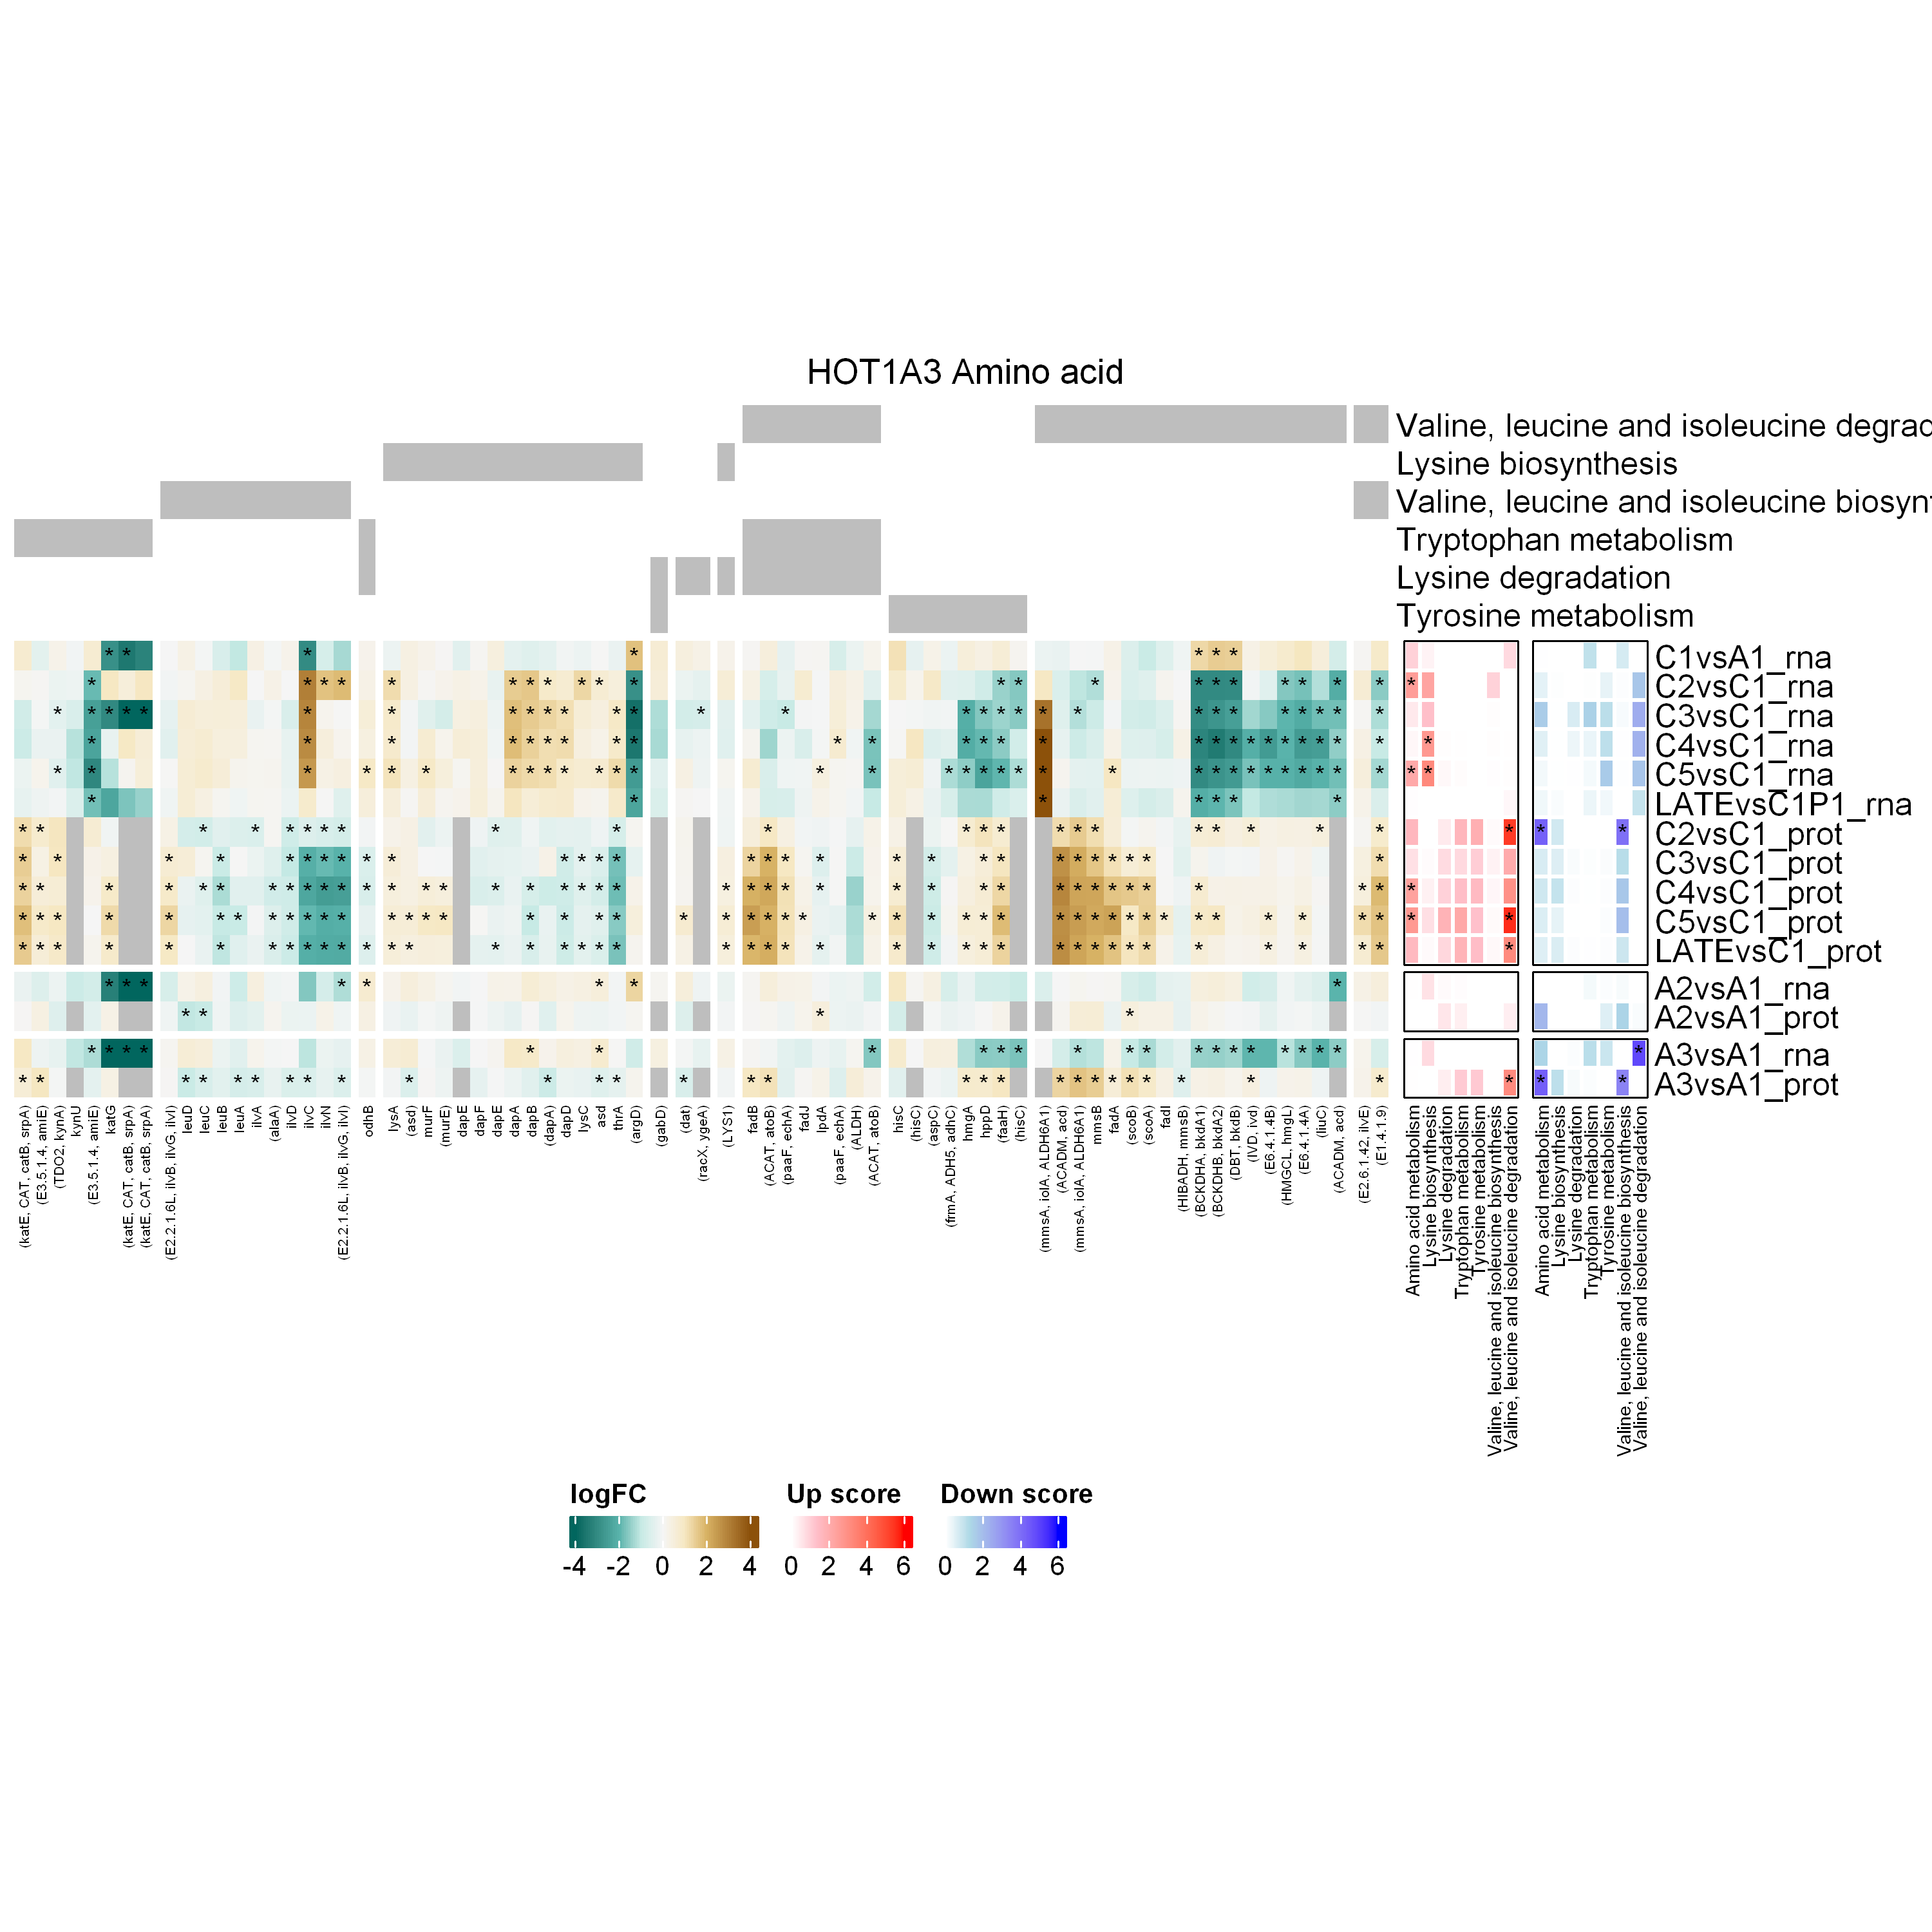

In [92]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    cluster_columns   = FALSE,
    #show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    column_names_gp = gpar(fontsize = 7),
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

In [93]:
dput(toppaths)

structure(list(pathway = c("Amino acid metabolism", "Valine, leucine and isoleucine biosynthesis", 
"Lysine biosynthesis", "Valine, leucine and isoleucine degradation", 
"Lysine degradation", "Tyrosine metabolism", "Tryptophan metabolism"
)), row.names = c(NA, -7L), class = c("tbl_df", "tbl", "data.frame"
))


In [56]:
head(df_all)

contrast,gene_id,logFC,AveExpr,pvalue,padj,Assay,contrast1,Length,down,⋯,X,path_id,main,sub,module,path,pathway,ecpath,kegg_gene,prev_gene
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
C2 - C1,ACZ81_RS16015,1.5362447,0.8062054,4.418240e-08,9.826165e-05,Proteome,C2vsC1_prot,1497,FALSE,⋯,2585,K00140,09100 Metabolism,09101 Carbohydrate metabolism;09105 Amino acid metabolism;09106 Metabolism of other amino acids,Carbohydrate;Amino acid;other amino acids,"00640 Propanoate metabolism [PATH:ko00640];00562 Inositol phosphate metabolism [PATH:ko00562];00280 Valine, leucine and isoleucine degradation [PATH:ko00280];00410 beta-Alanine metabolism [PATH:ko00410]","Propanoate metabolism;Inositol phosphate metabolism;Valine, leucine and isoleucine degradation;beta-Alanine metabolism","K00140 mmsA, iolA, ALDH6A1; malonate-semialdehyde dehydrogenase (acetylating) / methylmalonate-semialdehyde dehydrogenase [EC:1.2.1.18 1.2.1.27]","mmsA, iolA, ALDH6A1",
C2 - C1,ACZ81_RS19455,1.5648136,0.4518796,1.133719e-07,1.260696e-04,Proteome,C2vsC1_prot,1776,FALSE,⋯,5536,,,,NA,,NA,,NA,
C2 - C1,ACZ81_RS03205,1.8519732,-0.9340314,2.173784e-07,1.611498e-04,Proteome,C2vsC1_prot,1758,FALSE,⋯,3507,K20035,09100 Metabolism,09102 Energy metabolism,Energy,00920 Sulfur metabolism [PATH:ko00920],Sulfur metabolism,K20035 dmdC; 3-(methylsulfanyl)propanoyl-CoA dehydrogenase [EC:1.3.99.41],dmdC,
C2 - C1,ACZ81_RS08660,1.2073415,-1.0444874,3.978691e-07,2.212152e-04,Proteome,C2vsC1_prot,1797,FALSE,⋯,4168,K20035,09100 Metabolism,09102 Energy metabolism,Energy,00920 Sulfur metabolism [PATH:ko00920],Sulfur metabolism,K20035 dmdC; 3-(methylsulfanyl)propanoyl-CoA dehydrogenase [EC:1.3.99.41],dmdC,
C2 - C1,ACZ81_RS11690,-0.7880224,2.6035957,6.292978e-07,2.439240e-04,Proteome,C2vsC1_prot,1443,TRUE,⋯,1149,K00134,09100 Metabolism;09130 Environmental Information Processing;09160 Human Diseases;09180 Brite Hierarchies,09101 Carbohydrate metabolism;09102 Energy metabolism;09132 Signal transduction;09171 Infectious disease: bacterial;09164 Neurodegenerative disease;09166 Cardiovascular disease;09182 Protein families: genetic information processing;09183 Protein families: signaling and cellular processes,Carbohydrate;Energy;Signal transduction;Infectious disease: bacterial;Neurodegenerative disease;Cardiovascular disease;Protein families: genetic information processing;Protein families: signaling and cellular processes,00010 Glycolysis / Gluconeogenesis [PATH:ko00010];00710 Carbon fixation in photosynthetic organisms [PATH:ko00710];04066 HIF-1 signaling pathway [PATH:ko04066];05130 Pathogenic Escherichia coli infection [PATH:ko05130];05132 Salmonella infection [PATH:ko05132];05010 Alzheimer disease [PATH:ko05010];05415 Diabetic cardiomyopathy [PATH:ko05415];04131 Membrane trafficking [BR:ko04131];04147 Exosome [BR:ko04147],Glycolysis / Gluconeogenesis;Carbon fixation;HIF-1 signaling pathway;Pathogenic Escherichia coli infection;Salmonella infection;Alzheimer disease;Diabetic cardiomyopathy;Membrane trafficking;Exosome,"K00134 GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]","GAPDH, gapA",
C2 - C1,ACZ81_RS08650,1.5014521,0.5599381,6.984270e-07,2.439240e-04,Proteome,C2vsC1_prot,2121,FALSE,⋯,877,K07516,09100 Metabolism,09101 Carbohydrate metabolism;09103 Lipid metabolism;09111 Xenobiotics biodegradation and metabolism,Carbohydrate;Lipid;Xenobiotics biodegradation and,00650 Butanoate metabolism [PATH:ko00650];00071 Fatty acid degradation [PATH:ko00071];00362 Benzoate degradation [PATH:ko00362],Butanoate metabolism;Fatty acid degradation;Benzoate degradation,K07516 fadN; 3-hydroxyacyl-CoA dehydrogenase [EC:1.1.1.35],fadN,


In [57]:
sessionInfo()

R version 4.2.0 (2022-04-22 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default

locale:
[1] LC_COLLATE=English_Israel.utf8  LC_CTYPE=English_Israel.utf8   
[3] LC_MONETARY=English_Israel.utf8 LC_NUMERIC=C                   
[5] LC_TIME=English_Israel.utf8    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.14.0       ggrepel_0.9.1              
 [3] ComplexUpset_1.3.3          circlize_0.4.15            
 [5] corrplot_0.92               pheatmap_1.0.12            
 [7] lubridate_1.9.2             forcats_1.0.0              
 [9] stringr_1.5.0               dplyr_1.1.0                
[11] purrr_1.0.1                 readr_2.1.4                
[13] tidyr_1.3.0                 tibble_3.1.8               
[15] tidyverse_2.0.0             readxl_1.4.2               
[17] goseq_1.50.0                gen